In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlretrieve
import xlrd
import re

In [ ]:
# #Download data from the source web page
# url = 'https://www.foreignlaborcert.doleta.gov/pdf/PerformanceData/2017/H-1B_Disclosure_Data_FY17.xlsx'
# urlretrieve(url, './Data/H-1B_Disclosure_Data_FY17.xlsx')

In [2]:
#Open excel data file
file = './Data/H-1B_Disclosure_Data_FY17_.xlsx'
data = pd.ExcelFile(file)

In [3]:
#Check number of cheets in excel file
print(data.sheet_names)

['PDD_main']


In [4]:
#Read data frame from excel sheet
df1 = data.parse('PDD_main')

In [5]:
df1.columns

Index(['CASE_NUMBER', 'CASE_STATUS', 'CASE_SUBMITTED', 'DECISION_DATE',
       'VISA_CLASS', 'EMPLOYMENT_START_DATE', 'EMPLOYMENT_END_DATE',
       'EMPLOYER_NAME', 'EMPLOYER_BUSINESS_DBA', 'EMPLOYER_ADDRESS',
       'EMPLOYER_CITY', 'EMPLOYER_STATE', 'EMPLOYER_POSTAL_CODE',
       'EMPLOYER_COUNTRY', 'EMPLOYER_PROVINCE', 'EMPLOYER_PHONE',
       'EMPLOYER_PHONE_EXT', 'AGENT_REPRESENTING_EMPLOYER',
       'AGENT_ATTORNEY_NAME', 'AGENT_ATTORNEY_CITY', 'AGENT_ATTORNEY_STATE',
       'JOB_TITLE', 'SOC_CODE', 'SOC_NAME', 'NAICS_CODE', 'TOTAL_WORKERS',
       'NEW_EMPLOYMENT', 'CONTINUED_EMPLOYMENT', 'CHANGE_PREVIOUS_EMPLOYMENT',
       'NEW_CONCURRENT_EMPLOYMENT', 'CHANGE_EMPLOYER', 'AMENDED_PETITION',
       'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'PW_UNIT_OF_PAY',
       'PW_WAGE_LEVEL', 'PW_SOURCE', 'PW_SOURCE_YEAR', 'PW_SOURCE_OTHER',
       'WAGE_RATE_OF_PAY_FROM', 'WAGE_RATE_OF_PAY_TO', 'WAGE_UNIT_OF_PAY',
       'H1B_DEPENDENT', 'WILLFUL_VIOLATOR', 'SUPPORT_H1B', 'LABOR_CON_AGREE',

In [6]:
#Recover only necesary columns
df1_reduced = df1[['EMPLOYER_NAME', 'JOB_TITLE', 'SOC_NAME', 'FULL_TIME_POSITION', \
                   'PREVAILING_WAGE', 'PW_UNIT_OF_PAY', 'WORKSITE_CITY', \
                   'WORKSITE_COUNTY', 'WORKSITE_STATE', 'WORKSITE_POSTAL_CODE']]

In [7]:
#Rename columns to meaningful and easier names
df1_reduced.columns = ['employer', 'job_title', 'occupational_name', 'full_time', \
                       'prevailing_wage', 'wage_period', 'city', 'county', 'state', \
                       'postal_code']
df1_reduced.head()

,employer,job_title,occupational_name,full_time,prevailing_wage,wage_period,city,county,state,postal_code
0,DISCOVER PRODUCTS INC.,ASSOCIATE DATA INTEGRATION,COMPUTER SYSTEMS ANALYSTS,Y,59197.0,Year,RIVERWOODS,LAKE,IL,60015
1,DFS SERVICES LLC,SENIOR ASSOCIATE,OPERATIONS RESEARCH ANALYSTS,Y,49800.0,Year,RIVERWOODS,LAKE,IL,60015
2,EASTBANC TECHNOLOGIES LLC,.NET SOFTWARE PROGRAMMER,COMPUTER PROGRAMMERS,Y,76502.0,Year,WASHINGTON,NaN,DC,20007
3,INFO SERVICES LLC,PROJECT MANAGER,"COMPUTER OCCUPATIONS, ALL OTHER",Y,90376.0,Year,JERSEY CITY,HUDSON,NJ,07302
4,BB&T CORPORATION,ASSOCIATE - ESOTERIC ASSET BACKED SECURITIES,CREDIT ANALYSTS,Y,116605.0,Year,NEW YORK,NEW YORK,NY,10036


In [8]:
df1_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624650 entries, 0 to 624649
Data columns (total 10 columns):
employer             624594 non-null object
job_title            624645 non-null object
occupational_name    624647 non-null object
full_time            624645 non-null object
prevailing_wage      624649 non-null float64
wage_period          624604 non-null object
city                 624637 non-null object
county               623471 non-null object
state                624641 non-null object
postal_code          624631 non-null object
dtypes: float64(1), object(9)
memory usage: 47.7+ MB


In [9]:
#Drop rows with null values and reset index
df_drop = df1_reduced.dropna(axis=0, how='any').reset_index(drop=True)

In [10]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623346 entries, 0 to 623345
Data columns (total 10 columns):
employer             623346 non-null object
job_title            623346 non-null object
occupational_name    623346 non-null object
full_time            623346 non-null object
prevailing_wage      623346 non-null float64
wage_period          623346 non-null object
city                 623346 non-null object
county               623346 non-null object
state                623346 non-null object
postal_code          623346 non-null object
dtypes: float64(1), object(9)
memory usage: 47.6+ MB


In [11]:
df_drop.head()

,employer,job_title,occupational_name,full_time,prevailing_wage,wage_period,city,county,state,postal_code
0,DISCOVER PRODUCTS INC.,ASSOCIATE DATA INTEGRATION,COMPUTER SYSTEMS ANALYSTS,Y,59197.0,Year,RIVERWOODS,LAKE,IL,60015
1,DFS SERVICES LLC,SENIOR ASSOCIATE,OPERATIONS RESEARCH ANALYSTS,Y,49800.0,Year,RIVERWOODS,LAKE,IL,60015
2,INFO SERVICES LLC,PROJECT MANAGER,"COMPUTER OCCUPATIONS, ALL OTHER",Y,90376.0,Year,JERSEY CITY,HUDSON,NJ,07302
3,BB&T CORPORATION,ASSOCIATE - ESOTERIC ASSET BACKED SECURITIES,CREDIT ANALYSTS,Y,116605.0,Year,NEW YORK,NEW YORK,NY,10036
4,"SUNTRUST BANKS, INC.",CREDIT RISK METRICS SPECIALIST,"FINANCIAL SPECIALISTS, ALL OTHER",Y,59405.0,Year,ATLANTA,FULTON,GA,30303


In [12]:
#Cleaning column postal_code
i=0
to_drop = []
for code in df_drop.postal_code:
    # Rows with only letters in the postal code to drop
    if re.match('[A-Z]', code):
        #print(code, data.iloc[i, 4], data.iloc[i, 5], data.iloc[i, 6])
        to_drop.append(i)
    if len(code) > 5 :
        # Keep only first 5 digits of postal code
        # Codes can be in 9 digit format with or without '-'
        # or with special character after 5th digit
        if re.match('[0-9]{5}\S', code):
            df_drop.iloc[i, 7] = code[:5]
        # Keep only 5 digits when postal_code starts with special characters
        elif re.match('\S+[0-9]{5}', code):
            df_drop.iloc[i, 7] = code[-5:]
        # Eliminate space after 5th character    
        elif re.match('[0-9]{5} *', code):
            df_drop.iloc[i, 7] = code[-5:]
        else:
            to_drop.append(i)
    i += 1
df_drop = df_drop.drop(to_drop).reset_index(drop=True)

In [13]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623271 entries, 0 to 623270
Data columns (total 10 columns):
employer             623271 non-null object
job_title            623271 non-null object
occupational_name    623271 non-null object
full_time            623271 non-null object
prevailing_wage      623271 non-null float64
wage_period          623271 non-null object
city                 623271 non-null object
county               623271 non-null object
state                623271 non-null object
postal_code          623271 non-null object
dtypes: float64(1), object(9)
memory usage: 47.6+ MB


In [14]:
#Possible values for column full_time
df_drop.full_time.unique()

array(['Y', 'N'], dtype=object)

In [17]:
#Total rows corresponding to no full time jobs
no_full = len(df_drop[df_drop.full_time == 'N'])
total_jobs = len(df_drop)
print('Number of non full time job applications: {}'.format(no_full))
print('Total number of job applications: {}'.format(total_jobs))

Number of non full time job applications: 13840
Total number of job applications: 623271


In [18]:
print('No full time jobs corresponds to {}% of the total lines in the data frame'.format(no_full/total_jobs*100))

No full time jobs corresponds to 2.220542909905964% of the total lines in the data frame


In [19]:
#Wage period distribution for non yearly salaries
df_drop.wage_period[df_drop.full_time == 'N'].value_counts()

Hour    13826
Year       14
Name: wage_period, dtype: int64

In [20]:
#There are only 14 rows with Year value for wage_period, we drop them 
#and for the others later we are going to
#calculate a yearly salary based on their hourly salary
drop_list = df_drop.wage_period[(df_drop.full_time == 'N') & \
                                (df_drop.wage_period == 'Year')].index
df_drop = df_drop.drop(drop_list)

In [21]:
len(df_drop)

623257

In [22]:
#Possible values for wage_period
df_drop.wage_period.unique()

array(['Year', 'Hour', 'Month', 'Week', 'Bi-Weekly'], dtype=object)

In [23]:
#Change some columns to category type to save memory
for col in ['job_title', 'occupational_name', 'full_time', \
            'wage_period', 'state', 'postal_code']:
    df_drop[col] = df_drop[col].astype('category')

df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623257 entries, 0 to 623270
Data columns (total 10 columns):
employer             623257 non-null object
job_title            623257 non-null category
occupational_name    623257 non-null category
full_time            623257 non-null category
prevailing_wage      623257 non-null float64
wage_period          623257 non-null category
city                 623257 non-null object
county               623257 non-null object
state                623257 non-null category
postal_code          623257 non-null category
dtypes: category(6), float64(1), object(3)
memory usage: 34.3+ MB


In [24]:
df_drop.describe()

,prevailing_wage
count,6.232570e+05
mean,7.324061e+04
std,2.576827e+05
min,0.000000e+00
25%,5.688000e+04
50%,7.022100e+04
75%,8.914900e+04
max,2.016227e+08


In [25]:
#Check how many rows have a zero value
len(df_drop[df_drop.prevailing_wage == 0])

10

In [26]:
#Drop rows with zero value for prevailing_wage
df_drop = df_drop[df_drop.prevailing_wage > 0]
df_drop.describe()

,prevailing_wage
count,6.232470e+05
mean,7.324179e+04
std,2.576846e+05
min,7.250000e+00
25%,5.688800e+04
50%,7.022100e+04
75%,8.914950e+04
max,2.016227e+08


In [27]:
#Function to change non annual salaries to yearly salaries
def annual_salary(row):
    if row.wage_period == 'Year': return row.prevailing_wage
    if row.wage_period == 'Month': return row.prevailing_wage * 12
    if row.wage_period == 'Bi-Weekly': return row.prevailing_wage * 26
    if row.wage_period == 'Week': return row.prevailing_wage * 52
    if row.wage_period == 'Hour': return row.prevailing_wage * 2080

In [28]:
#Convert all salaries to yearly salaries in data frame using 
#the function annual_salary
df_drop.prevailing_wage = df_drop.apply(annual_salary, axis = 1)

In [29]:
#Drop wage_period and full_time columns from data frame
df_drop = df_drop.drop(['full_time', 'wage_period'], axis=1)

In [30]:
df_drop.describe()

,prevailing_wage
count,6.232470e+05
mean,9.969498e+04
std,1.811059e+06
min,2.558000e+01
25%,5.953000e+04
50%,7.178100e+04
75%,9.035350e+04
max,4.013610e+08


In [31]:
#Salaries greater than 5 milllion a year can be considered as 
#input errors
print('There are {} rows with a salary greater than \
$1 million'.format(len(df_drop[df_drop.prevailing_wage > 1e+06])))

There are 127 rows with a salary greater than $1 million


In [32]:
#We are going to ignore those lines
df_drop = df_drop[df_drop.prevailing_wage < 1e+06]
df_drop.describe()

,prevailing_wage
count,623120.000000
mean,77234.453497
std,27531.257474
min,25.580000
25%,59530.000000
50%,71781.000000
75%,90300.000000
max,976656.000000


In [33]:
print('There are {} rows with a salary smaller than \
$15000'.format(len(df_drop[df_drop.prevailing_wage < 15000])))

There are 1 rows with a salary smaller than $15000


In [34]:
#We drop that line
df_drop = df_drop[df_drop.prevailing_wage > 15000]
df_drop.describe()

,prevailing_wage
count,623119.000000
mean,77234.577405
std,27531.105822
min,15080.000000
25%,59530.000000
50%,71781.000000
75%,90300.000000
max,976656.000000


/home/pfgr/anaconda3/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


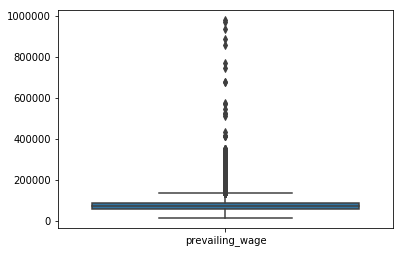

In [35]:
sns.boxplot(data=df_drop)
plt.show()

In [36]:
print('There are {} rows with a salary greater than \
$300000'.format(len(df_drop[df_drop.prevailing_wage > 300000])))

There are 57 rows with a salary greater than $300000


/home/pfgr/anaconda3/envs/py3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


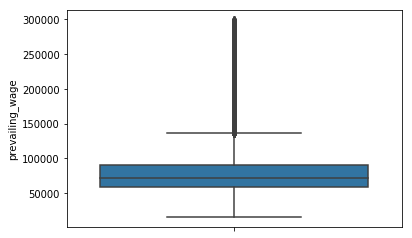

In [37]:
sns.boxplot(y='prevailing_wage', \
            data=df_drop[df_drop.prevailing_wage < 300000])
plt.show()

In [38]:
df_clean = df_drop.reset_index(drop=True)

In [39]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 623119 entries, 0 to 623118
Data columns (total 8 columns):
employer             623119 non-null object
job_title            623119 non-null category
occupational_name    623119 non-null category
prevailing_wage      623119 non-null float64
city                 623119 non-null object
county               623119 non-null object
state                623119 non-null category
postal_code          623119 non-null category
dtypes: category(4), float64(1), object(3)
memory usage: 28.4+ MB


In [40]:
df_clean.to_csv('./Data/H1B_2017.csv')